# About

### What is done in this notebook:
  * Creating xgboost ranker model to rank candidates gotten from covisitation matrices
  * Calculating score on validation set
  * Creating submission for public test set
  
### About data
  * For each session in train,val,test sets, 40 candidate items (more is better) are generated using handcrafted rules and covisitation matrices 
  * For generated candidates various features are added and train, val, test sets prepared
  * This data is saved in "prepared-candidates-from-covisitation-mat-3" dataset.
  * Train set negatives are sampled so only 0.2 of data is kept
  * Val and test data is not downsampled and is split into 10 files because of memory consumption

### Thanks
* Thanks to <a href='https://www.kaggle.com/cdeotte'>Chris</a>, <a href='https://www.kaggle.com/radek1'>Radek</a>, and others that supplied knowledge, code, comments

# Import 

In [1]:
VER = 1

In [2]:
import xgboost as xgb
import datetime
import cudf
import glob
import sys
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
import psutil
import numpy as np
import gc
import time
import random
from time import sleep

# Config

In [3]:
class cfg:
    local         = False # on local machine only some testing is done (low memory)
    seed          = 101
    folds_num     = 5
    # train_folds   = [0] # it is faster to check model improvement of only one fold, when possible
    train_folds   = list(range(folds_num))
    val_fold      = 0 # validate only on this fold
    test_folds    = train_folds # predict using all train folds

In [4]:
# On my local machine, I found it good to set resource limit to number a bit above available RAM 

if cfg.local:
    import resource
    resource.setrlimit(resource.RLIMIT_AS, (int(21*(10**9)), -1))
    print(resource.getrlimit(resource.RLIMIT_AS)[0] / 1e9, 'GB')

### Seed

In [5]:
# Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY
def set_seed(seed = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

    cudf.cupy.random.seed(seed)

    print('Setting seed done')
    
set_seed(cfg.seed)

Setting seed done


### File paths:

In [6]:
print('Train:')
train_candidates_files = {}
for ev in ['clicks', 'carts', 'orders']:
    if cfg.local:
        train_candidates_files[ev] = glob.glob(f'./train_candidates_{ev}*')
    else:
        train_candidates_files[ev] = glob.glob(f'/kaggle/input/prepared-candidates-from-covisitation-mat-3/train_candidates_{ev}*')
    print(len(train_candidates_files[ev]))
    train_candidates_files[ev] = train_candidates_files[ev][0]
    
print('Val:')
val_candidates_files = {}
for ev in ['clicks', 'carts', 'orders']:
    if cfg.local:
        val_candidates_files[ev] = glob.glob(f'./val_{ev}_candidates_*')
    else:
        val_candidates_files[ev] = glob.glob(f'/kaggle/input/prepared-candidates-from-covisitation-mat-3/val_{ev}_candidates_*')
    print(len(val_candidates_files[ev]))

print('Test:')
test_candidates_files = {}
for ev in ['clicks', 'carts', 'orders']:
    if cfg.local:
        test_candidates_files[ev] = glob.glob(f'./test_{ev}_candidates_*')
    else:
        test_candidates_files[ev] = glob.glob(f'/kaggle/input/prepared-candidates-from-covisitation-mat-3/test_{ev}_candidates_df_*')
    print(len(test_candidates_files[ev]))


Train:
1
1
1
Val:
10
10
10
Test:
10
10
10


In [7]:
if cfg.local:
    folds_path = glob.glob('./df_fold.pqt')
else:
    folds_path = glob.glob('/kaggle/input/prepared-candidates-from-covisitation-mat-3/df_fold.pqt')

if len(folds_path) == 1:
    folds_path = folds_path[0]
    print('Folds df present')
else:
#     print('Folds missing')
    assert False, 'Folds missing'

Folds df present


In [8]:
# # Last week of train set is used for training here

if cfg.local:
    train_files = glob.glob('../../../downloaded_data/split_data_local_validation/test_parquet/*')
    train_labels_path = '../../../downloaded_data/split_data_local_validation/test_labels.parquet'
    
    test_files = glob.glob('../../../downloaded_data/split_data/test_parquet/*')
else:
    train_files = glob.glob('/kaggle/input/otto-validation/test_parquet/*')
    train_labels_path = '/kaggle/input/otto-validation/test_labels.parquet'

    test_files = glob.glob('/kaggle/input/otto-chunk-data-inparquet-format/test_parquet/*')

# Helper functions

In [9]:
def ts_format(ts):
    return datetime.datetime.fromtimestamp(ts).strftime("%b %d %Y  %H:%M:%S")
def print_date_ts(ts, end='\n'):
    print(ts_format(ts), end=end)
def print_date(d, end='\n'):
    print(d.strftime("%b %d %Y  %H:%M:%S"), end=end)
def mils_format(x):
    return f'{x:,}'
def len_mils(x):
    return mils_format(len(x))
def load_df_from_files(files_list):
    df = cudf.DataFrame()
    for f in files_list:
        df = cudf.concat([df, cudf.read_parquet(f)], ignore_index=True)
    df = df.reset_index(drop=True)
    return df
def preview_df(df, num_to_show=1):
    print(len_mils(df))
    display(df.head(num_to_show))

## Track gpu memory

* This part of notebook is used only for plotting GPU memory consumption over time
* It is not neccessary, but exploratory :)

In [10]:
track_gpu_mem = True

In [11]:
gpu_available = None

try:
    subprocess.check_output('nvidia-smi')
    gpu_available = True

    print('Nvidia GPU detected!')
except Exception:
    gpu_available = False
    track_gpu_mem = False

    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [12]:
if gpu_available:
    dev0 = cudf.cupy.cuda.Device(0)
    def print_gpu_mem_info():
        free_memory, total_memory = dev0.mem_info
        print('Free -', free_memory // 1024**2, 'MiB', '\tTotal -', total_memory // 1024**2, 'MiB')
    print_gpu_mem_info()

Free - 15805 MiB 	Total - 16280 MiB


In [13]:
def clear_gpu_log():
    with open('./gpu-report.csv', 'w') as file:
        cols = [
            'date', 'used_MiB'
        ]
        line = ','.join(cols) + '\n'
        file.write(line)

def start_logging_gpu_info(every='2'):
    log_gpu_subprocess = subprocess.Popen(
        ["watch","-n",every, "./track-gpu.sh"],
        stdout=subprocess.PIPE
    )
    
    return log_gpu_subprocess

def stop_logging_gpu_info():
    for proc in psutil.process_iter():
        if 'watch' in proc.name() and './track-gpu.sh' in proc.cmdline():
            proc.kill()

def plot_gpu_usage(mins_to_plot=2, interval=2):
    if not os.path.exists('./gpu-report.csv'):
        return
        
    df = pd.read_csv('./gpu-report.csv')

    entries_num = int(mins_to_plot * 60 // interval)
    df = df[-entries_num:]
    df['date'] = df.date.apply(lambda d: datetime.datetime.fromisoformat(d))

    plt.figure(figsize=(12,4))
    plt.title(f'used GPU Memory')
    plt.plot(df.date, df['used_MiB'], color='blue')
    plt.show()

def create_file_with_logging_command():
    with open('./track-gpu.sh', 'w') as file:
        file.write(
            'values=$(nvidia-smi | sed -n \'10p\' | awk \'{print $9}\' | sed -nz \'s/MiB\\n//gp\'); echo $(date +%Y-%m-%d#%H:%M:%S),$(($values)) >> ' + f'{os.getcwd()}/gpu-report.csv'
        )

def run_logging_file():
    subprocess.run(
        [f'{os.getcwd()}/track-gpu.sh'],
        shell=True
    )

def allow_logging_file_execution():
    os.system('chmod a+x ./track-gpu.sh')

In [14]:
if track_gpu_mem:
    create_file_with_logging_command()
    allow_logging_file_execution()

    stop_logging_gpu_info()
    clear_gpu_log()
    run_logging_file() # to add one memory value
    
    watch_process = start_logging_gpu_info()
    
    df = pd.read_csv('./gpu-report.csv')
    df.tail()

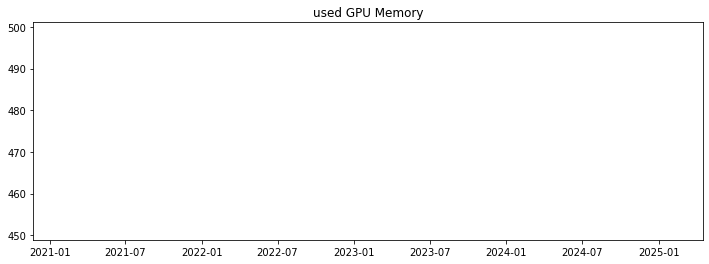

In [15]:
if track_gpu_mem:
    sleep(2)
    plot_gpu_usage()

# Load data

### Load train data

In [16]:
type2id_df = cudf.DataFrame({'type': ['clicks', 'carts', 'orders'], 'type_id': [0,1,2]})
type2id_df.type_id = type2id_df.type_id.astype('int8')

def read_transform_file(f):
    df = cudf.read_parquet(f)
    df.ts = (df.ts/1000).astype('int32')
    df = cudf.merge(df, type2id_df, on='type', how='inner').drop('type', axis=1).rename(columns={'type_id': 'type'})
    return df
def load_train_week():
    train = cudf.DataFrame()
    for f in train_files:
        train = cudf.concat([train, read_transform_file(f)], ignore_index=True)

    train = train.reset_index(drop=True)
    return train

In [17]:
train = load_train_week()
preview_df(train)

7,683,577


,session,aid,ts,type
0,12090055,1186096,1661448257,0


In [18]:
print_date_ts(train['ts'].min())
print_date_ts(train['ts'].max())

Aug 21 2022  22:00:00
Aug 28 2022  21:59:56


### Load train labels

* Train labels consist of (session,aid_list) pairs that did happen in session continuation

In [19]:
def load_train_week_labels(do_print=False):
    train_labels = cudf.read_parquet(train_labels_path)

    if do_print:
        print(train_labels.shape)
        preview_df(train_labels)

    # Change ground_truth from "aid in list" to "one aid per row" -> (session, type) pairs will now be repeated where len(ground_truth) was >=2
    train_labels = cudf.merge(train_labels, type2id_df, on='type', how='inner').drop('type', axis=1).rename(columns={'type_id': 'type'})
    train_labels = train_labels.explode('ground_truth').rename(columns={'ground_truth': 'aid'})[['session', 'type', 'aid']]
    train_labels = train_labels.astype({
        'session': 'int32',
        'aid': 'int32',
        'type': 'int8',
    })

    if do_print:
        print(train_labels.shape)
        preview_df(train_labels)

    # * Add columns ground_truth - gt that marks all pairs as 1, that is they happened
    train_labels['gt'] = 1
    train_labels['gt'] = train_labels['gt'].astype('int8')
    train_labels.dtypes

    return train_labels

In [20]:
train_labels = load_train_week_labels(do_print=True)

(2212692, 3)
2,212,692


,session,type,ground_truth
0,11098528,clicks,[1679529]


(2650372, 3)
2,650,372


,session,type,aid
0,11118728,2,192760


### Load train candidates function

In [21]:
def get_train_df(event):
    candidates_df = cudf.read_parquet(train_candidates_files[event])
    
    return candidates_df

### Load folds

In [22]:
df_fold = cudf.read_parquet(folds_path)
df_fold.head(2)

,session,fold
0,11098528,1
1,11098529,2


# Calc model val score

In [23]:
def get_val_data(event):
    val_data = cudf.DataFrame()
    for f in val_candidates_files[event]:
        val_data = cudf.concat([val_data, cudf.read_parquet(f).sort_values('session')], ignore_index=True)
    val_data = val_data.reset_index(drop=True)
    val_data['session'] = val_data['session'].astype('int32')
    val_data['aid'] = val_data['aid'].astype('int32')
    return val_data

In [24]:
def calc_event_recall(ev_preds_df, event_name, clip_amount=20):
    sub = ev_preds_df
    sub['session'] = sub.session_type.apply(lambda x: int(x.split('_')[0]))
    # sub.labels = sub.labels.apply(lambda x: x[:clip_amount])
    sub.labels = sub.labels.apply(lambda x: x[:clip_amount])

    val_labels = pd.read_parquet(train_labels_path)
    val_labels = val_labels.loc[val_labels['type']==event_name]

    val_labels = pd.merge(val_labels, df_fold.to_pandas(), on='session')
    val_labels = val_labels.loc[val_labels.fold == cfg.val_fold]
    del val_labels['fold']

    val_labels = val_labels.merge(sub, how='left', on=['session'])

    val_labels['hits'] = val_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)

    val_labels['gt_count'] = val_labels.ground_truth.str.len().clip(0, clip_amount)

    recall = val_labels['hits'].sum() / val_labels['gt_count'].sum()
    print(f'{event_name} recall =',recall)

    return recall
def calc_val_score(event_name, clip_amount=20):
    # events_names = ['clicks', 'carts', 'orders']
    events_names = [event_name]

    preds = {}
    for event_name in events_names:
        print(event_name)
        
        model = xgb.Booster()
        model.load_model(f'XGB_fold{valid_fold_num}_{event_name}.xgb')
        model.set_param({'predictor': 'gpu_predictor'})
        
        preds[event_name] = []
        for i,f in enumerate(val_candidates_files[event_name]):
            print(i, end=' ')

            val_candidates = cudf.read_parquet(f)
            val_candidates = val_candidates.sort_values('session')
            
            groups = val_candidates.groupby('session').size().to_frame('size')['size']
            dtest = xgb.DMatrix(data=val_candidates[feature_cols[event_name]], group=groups)
            
            preds[event_name].append(model.predict(dtest))
            del dtest, val_candidates
        
        preds[event_name] = np.concatenate(preds[event_name], axis=None)
        np.save(f'val_preds_{event_name}.npy', preds[event_name])
        print()

    predictions = {}
    sub = {}
    predictions[event_name] = get_val_data(event_name)[['session','aid']]

    predictions[event_name]['pred'] = preds[event_name]

    # Pick top 20 predictions:
    predictions[event_name] = predictions[event_name].sort_values(['session','pred'], ascending=[True,False]).reset_index(drop=True)
    predictions[event_name]['n'] = predictions[event_name].groupby('session').aid.cumcount().astype('int8')
    predictions[event_name] = predictions[event_name].loc[predictions[event_name].n<clip_amount]
    del predictions[event_name]['pred']
    del predictions[event_name]['n']

    # Transform (session,aid) pairs to (session,string of all aids) pairs
    predictions[event_name] = predictions[event_name].to_pandas() # it was faster to do next functions in pandas then in cudf
    sub[event_name] = predictions[event_name].groupby('session').aid.apply(list)
    del predictions[event_name]

    sub[event_name] = sub[event_name].to_frame().reset_index()
    to_add_str = '_' + event_name
    sub[event_name]['session'] = sub[event_name].session.astype('str') + to_add_str

    sub[event_name].columns = ['session_type', 'labels']

    return calc_event_recall(sub[event_name], event_name, clip_amount)

# Model config

In [25]:
def get_feature_cols(df, event_name):
    feature_cols = list(df.columns)
    
    remove_cols = [
        'session', 'aid', 'gt', 'fold',
    ]
    
    for col in remove_cols:
        if col in feature_cols:
            feature_cols.remove(col)
    
    return feature_cols
def get_target_cols():
    return ['gt']
def get_qid_cols():
    return ['session']

In [26]:
feature_cols = {}

In [27]:
xgb_parms = {
    'objective':'rank:pairwise', 
    'tree_method':'gpu_hist', 
    'seed': cfg.seed, 
    'random_state': cfg.seed,
    'max_depth': 6,
    'min_child_weight': 100,
    'eta': 0.1,
    'gamma': 25.0,
    'learning_rate': 0.2,
    'colsample_bytree': 0.75,
    'subsample': 0.9,
    'eval_metric': 'ndcg',
}

# Clicks

In [28]:
print_gpu_mem_info()

Free - 15641 MiB 	Total - 16280 MiB


In [29]:
train_clicks = get_train_df('clicks')

train_clicks = cudf.merge(
    train_clicks, train_labels.loc[train_labels.type==0][['session', 'aid', 'gt']], 
    how='left', on=['session', 'aid'])

train_clicks['gt'] = train_clicks['gt'].fillna(0)
print(train_clicks.shape)

train_clicks = cudf.merge(train_clicks, df_fold, on='session', how='left')

# Delete all cols that do not improve score
del_cols = [
#         'type', 
    'ts_max', 
    'ts_min', 
    'ts_mean', 
    'ts_med',
    'ts_duration', 
#     'session_clicks',
    'session_carts', 
    'session_orders', 
#     'session_length',
    'repetitions',
    'aid_num_log', 
    'aid_clicks_num_log', 
    'aid_carts_num_log', 
    'aid_orders_num_log', 
    'aid_clicks_num_ps_log', 
    'aid_carts_num_ps_log',
    'aid_orders_num_ps_log',
#     'num_clicks_last_2_hours', 
#     'num_carts_last_2_hours',
#     'num_orders_last_2_hours', 
    'cart_order_diff_last_2_hours',
    'clicks_in_day_1',
    'clicks_in_day_2',
    'clicks_in_day_3',
    'type_mean'
]
for col in del_cols:
    if col in train_clicks.columns:
        del train_clicks[col]

feature_cols['clicks'] = get_feature_cols(train_clicks, 'clicks')
print(len(feature_cols['clicks']))
print(feature_cols['clicks'])

(17736650, 21)
7
['type', 'clicks_final_wgt', 'clicks_similarity_wgt', 'num_clicks_last_2_hours', 'num_carts_last_2_hours', 'num_orders_last_2_hours', 'session_length']


Fold 0


/opt/conda/lib/python3.7/site-packages/cudf/core/frame.py:2600: UserWarning: When using a sequence of booleans for `ascending`, `na_position` flag is not yet supported and defaults to treating nulls as greater than all numbers
  "When using a sequence of booleans for `ascending`, "


[0]	train-ndcg:0.88986	valid-ndcg:0.88973
[10]	train-ndcg:0.89024	valid-ndcg:0.89011
[20]	train-ndcg:0.89041	valid-ndcg:0.89035
[30]	train-ndcg:0.89030	valid-ndcg:0.89018
[40]	train-ndcg:0.89027	valid-ndcg:0.89016
[50]	train-ndcg:0.89036	valid-ndcg:0.89024
[60]	train-ndcg:0.89034	valid-ndcg:0.89021
[70]	train-ndcg:0.89039	valid-ndcg:0.89022
[80]	train-ndcg:0.89041	valid-ndcg:0.89025
[90]	train-ndcg:0.89043	valid-ndcg:0.89028
[100]	train-ndcg:0.89041	valid-ndcg:0.89028
[103]	train-ndcg:0.89041	valid-ndcg:0.89027
Fold 1
[0]	train-ndcg:0.88991	valid-ndcg:0.89013
[10]	train-ndcg:0.89019	valid-ndcg:0.89042
[20]	train-ndcg:0.89015	valid-ndcg:0.89047
[30]	train-ndcg:0.89013	valid-ndcg:0.89044
[40]	train-ndcg:0.89014	valid-ndcg:0.89044
[50]	train-ndcg:0.89021	valid-ndcg:0.89048
[60]	train-ndcg:0.89026	valid-ndcg:0.89048
[70]	train-ndcg:0.89027	valid-ndcg:0.89050
[80]	train-ndcg:0.89029	valid-ndcg:0.89053
[90]	train-ndcg:0.89031	valid-ndcg:0.89057
[100]	train-ndcg:0.89032	valid-ndcg:0.89058
[10

50

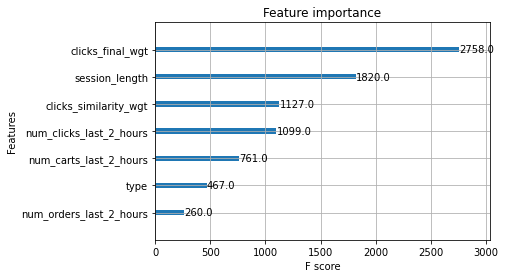

In [30]:
xgb_parms['learning_rate'] = 0.1
xgb_parms['max_depth'] = 8
xgb_parms['subsample'] = 0.9
xgb_parms['colsample_bytree'] = 0.8
xgb_parms['min_child_weight'] = 200

for valid_fold_num in cfg.train_folds:
    print('Fold', valid_fold_num)

    # X_train = train_clicks
    X_train = train_clicks.loc[train_clicks.fold != valid_fold_num]
#     X_train = X_train.sort_values('session')
    X_train = X_train.sort_values(['session', 'clicks_final_wgt'], ascending=[True, False])
    
    y_train = X_train['gt']
    groups = X_train.groupby('session').size().to_frame('size')['size']
    X_train = X_train[feature_cols['clicks']]
    
    X_valid = train_clicks.loc[train_clicks.fold == valid_fold_num]
    # X_valid = X_valid.sort_values('session')
    X_valid = X_valid.sort_values(['session', 'clicks_final_wgt'], ascending=[True, False])
    
    y_valid = X_valid['gt']
    val_groups = X_valid.groupby('session').size().to_frame('size')['size']
    X_valid = X_valid[feature_cols['clicks']]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, group=groups)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, group=val_groups)

    model = xgb.train(
        xgb_parms, 
        dtrain=dtrain,
        evals=[(dtrain,'train'),(dvalid,'valid')],
        num_boost_round=150,
        early_stopping_rounds=80,
        verbose_eval=10,
    )

    model.save_model(f'XGB_fold{valid_fold_num}_clicks.xgb')

calc_val_score('clicks')

_ = xgb.plot_importance(model, height=0.2)

del train_clicks
del X_train, y_train, X_valid, y_valid, dtrain, dvalid
gc.collect()

# 5166908232506884

In [31]:
# fig, ax = plt.subplots(figsize=(30, 30))
# plot_tree(model, num_trees=100, ax=ax)
# # fig.savefig('tree.png')
# plt.show()

In [32]:
# trees_df = model.trees_to_dataframe()
# num_leaves = trees_df.groupby('Tree').size()
# plt.plot(num_leaves)

In [33]:
# trees_df.loc[trees_df.Node < 1].Feature.value_counts()
# trees_df.loc[trees_df.Node < 5].Feature.value_counts()
# trees_df.loc[trees_df.Node > 10].Feature.value_counts()

In [34]:
print('Used params:')
print(list(xgb_parms.keys())[4:])
print(list(xgb_parms.values())[4:])

Used params:
['max_depth', 'min_child_weight', 'eta', 'gamma', 'learning_rate', 'colsample_bytree', 'subsample', 'eval_metric']
[8, 200, 0.1, 25.0, 0.1, 0.8, 0.9, 'ndcg']


In [35]:
del model
gc.collect()

105

In [36]:
# assert False

In [37]:
print_gpu_mem_info()

Free - 14551 MiB 	Total - 16280 MiB


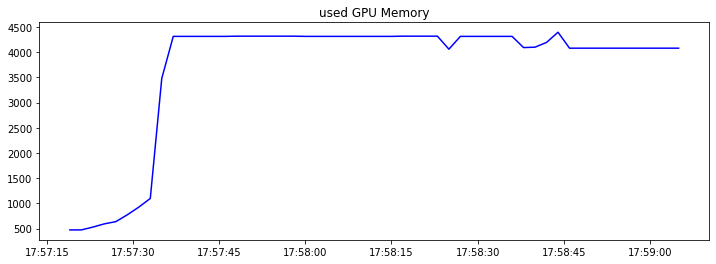

In [38]:
plot_gpu_usage()

# Carts

In [39]:
train_carts = get_train_df('carts')

# Adding both carts and orders as correct here
train_carts = cudf.merge(
    train_carts, train_labels.loc[train_labels.type!=0][['session', 'aid', 'gt']], how='left', on=['session', 'aid'])

# Delete all cols that do not improve score
del_cols = [
#     'type', 
    'ts_max', 'ts_min', 'ts_mean', 'ts_med',
#     'ts_duration', 
    'session_clicks',
    'session_carts', 
    'session_orders', 
#     'session_length',
    'repetitions',
    'aid_num_log', 
    'aid_clicks_num_log', 
    'aid_carts_num_log', 
    'aid_orders_num_log', 
#     'aid_clicks_num_ps_log', 
#     'aid_carts_num_ps_log', 
#     'aid_orders_num_ps_log',
    
    'num_clicks_last_2_hours', 
#     'num_carts_last_2_hours',
    'num_orders_last_2_hours', 
    'cart_order_diff_last_2_hours',
#     'carts_in_day_1', 
#     'orders_in_day_1', 
#     'carts_in_day_2', 
    'orders_in_day_2', 
    'carts_in_day_3', 
    'orders_in_day_3',
]
for col in del_cols:
    if col in train_carts.columns:
        del train_carts[col]

train_carts['gt'] = train_carts['gt'].fillna(0)
print(train_carts.shape)

train_carts = cudf.merge(train_carts, df_fold, on='session', how='left')
# preview_df(train_carts)

feature_cols['carts'] = get_feature_cols(train_carts, 'carts')
print(len(feature_cols['carts']))
print(feature_cols['carts'])

(18782460, 17)
14
['type', 'carts_final_wgt', 'top_buys_wgt', 'top_buy2buy_wgt', 'num_carts_last_2_hours', 'ts_duration', 'session_length', 'type_mean', 'aid_clicks_num_ps_log', 'aid_carts_num_ps_log', 'aid_orders_num_ps_log', 'carts_in_day_1', 'orders_in_day_1', 'carts_in_day_2']


Fold 0
[0]	train-ndcg:0.97942	valid-ndcg:0.97911
[10]	train-ndcg:0.97991	valid-ndcg:0.97966
[20]	train-ndcg:0.98031	valid-ndcg:0.97994
[30]	train-ndcg:0.98056	valid-ndcg:0.98016
[40]	train-ndcg:0.98067	valid-ndcg:0.98026
[50]	train-ndcg:0.98070	valid-ndcg:0.98029
[60]	train-ndcg:0.98071	valid-ndcg:0.98032
[70]	train-ndcg:0.98071	valid-ndcg:0.98034
[80]	train-ndcg:0.98072	valid-ndcg:0.98036
[90]	train-ndcg:0.98072	valid-ndcg:0.98036
[100]	train-ndcg:0.98072	valid-ndcg:0.98037
[101]	train-ndcg:0.98072	valid-ndcg:0.98037
Fold 1
[0]	train-ndcg:0.97906	valid-ndcg:0.97909
[10]	train-ndcg:0.97993	valid-ndcg:0.97984
[20]	train-ndcg:0.98036	valid-ndcg:0.98015
[30]	train-ndcg:0.98060	valid-ndcg:0.98038
[40]	train-ndcg:0.98069	valid-ndcg:0.98043
[50]	train-ndcg:0.98073	valid-ndcg:0.98047
[60]	train-ndcg:0.98075	valid-ndcg:0.98048
[70]	train-ndcg:0.98077	valid-ndcg:0.98049
[80]	train-ndcg:0.98078	valid-ndcg:0.98049
[84]	train-ndcg:0.98077	valid-ndcg:0.98048
Fold 2
[0]	train-ndcg:0.97921	valid-ndcg

0.4054100888973608

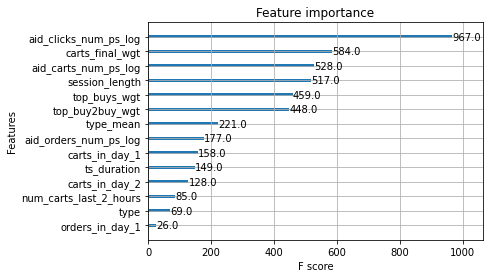

In [40]:
xgb_parms['learning_rate'] = 0.4
xgb_parms['max_depth'] = 8
xgb_parms['gamma'] = 15.0
xgb_parms['subsample'] = 0.9
xgb_parms['colsample_bytree'] = 0.75
xgb_parms['min_child_weight'] = 200
xgb_parms['max_delta_step'] = 0
xgb_parms['eta'] = 0.1
xgb_parms['eval_metric'] =  'ndcg'

for valid_fold_num in cfg.train_folds:
    print('Fold', valid_fold_num)

    # X_train = train_carts
    X_train = train_carts.loc[train_carts.fold != valid_fold_num]
    X_train = X_train.sort_values('session')
    
    y_train = X_train['gt']
    groups = X_train.groupby('session').size().to_frame('size')['size']
    X_train = X_train[feature_cols['carts']]
    
    X_valid = train_carts.loc[train_carts.fold == valid_fold_num]
    X_valid = X_valid.sort_values('session')
    
    y_valid = X_valid['gt']
    val_groups = X_valid.groupby('session').size().to_frame('size')['size']
    X_valid = X_valid[feature_cols['carts']]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, group=groups)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, group=val_groups)

    gc.collect()
    
    model = xgb.train(
        xgb_parms, 
        dtrain=dtrain,
        evals=[(dtrain,'train'),(dvalid,'valid')],
        num_boost_round=150,
        verbose_eval=10,
        early_stopping_rounds=20,
    )

    model.save_model(f'XGB_fold{valid_fold_num}_carts.xgb')

_ = xgb.plot_importance(model)

del train_carts
del X_train, y_train, X_valid, y_valid, dtrain, dvalid
gc.collect()

calc_val_score('carts')
# 4057566673020604

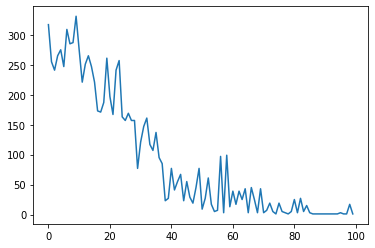

In [41]:
trees_df = model.trees_to_dataframe()
num_leaves = trees_df.groupby('Tree').size()
plt.plot(num_leaves)

In [42]:
# trees_df.loc[trees_df.Node < 1].Feature.value_counts()
# trees_df.loc[trees_df.Node < 5].Feature.value_counts()
# trees_df.loc[trees_df.Node > 10].Feature.value_counts()

In [43]:
del model
gc.collect()

42

Free - 14543 MiB 	Total - 16280 MiB


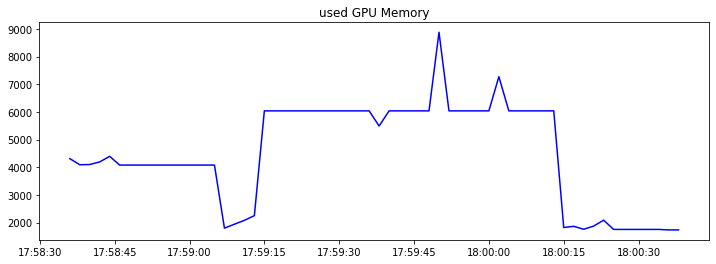

In [44]:
time.sleep(2)
print_gpu_mem_info()
plot_gpu_usage()

# Orders

In [45]:
train = get_train_df('orders')
print(len_mils(train))

# Set both carts and orders as correct:
# train_orders = cudf.merge(train, train_labels.loc[train_labels.type!=0][['session', 'aid', 'gt']], how='left', on=['session', 'aid'])
# Set only orders as correct:
train_orders = cudf.merge(train, train_labels.loc[train_labels.type==2][['session', 'aid', 'gt']], how='left', on=['session', 'aid'])

# Delete all cols that do not improve score
del_cols = [
#         'type', 
    'ts_max', 'ts_min', 'ts_mean', 'ts_med',
    'ts_duration', 
    'session_clicks',
    'session_carts', 
    'session_orders', 
    'session_length',
    'repetitions',
    'aid_num_log', 
    'aid_clicks_num_log', 
    'aid_carts_num_log', 
    'aid_orders_num_log', 
#     'aid_clicks_num_ps_log', 
#     'aid_carts_num_ps_log', 
#     'aid_orders_num_ps_log',
    
#     'num_clicks_last_2_hours', 
#     'num_carts_last_2_hours',
#     'num_orders_last_2_hours', 
#     'cart_order_diff_last_2_hours',
    
#     'carts_in_day_1', 
#     'orders_in_day_1', 
    'carts_in_day_2', 
    'orders_in_day_2', 
    'carts_in_day_3', 
    'orders_in_day_3',
    #'type_mean',
]
for col in del_cols:
    if col in train_orders.columns:
        del train_orders[col]

train_orders['gt'] = train_orders['gt'].fillna(0)
del train

train_orders = cudf.merge(train_orders, df_fold, on='session', how='left')

feature_cols['orders'] = get_feature_cols(train_orders, 'orders')
print(len(feature_cols['orders']))
print(feature_cols['orders'])

18,541,269
13
['type', 'orders_final_wgt', 'top_buys_wgt', 'top_buy2buy_wgt', 'num_clicks_last_2_hours', 'num_carts_last_2_hours', 'num_orders_last_2_hours', 'type_mean', 'aid_clicks_num_ps_log', 'aid_carts_num_ps_log', 'aid_orders_num_ps_log', 'carts_in_day_1', 'orders_in_day_1']


Fold 0
[0]	train-ndcg:0.99337	valid-ndcg:0.99328
[10]	train-ndcg:0.99336	valid-ndcg:0.99328
[20]	train-ndcg:0.99339	valid-ndcg:0.99328
[30]	train-ndcg:0.99341	valid-ndcg:0.99327
[34]	train-ndcg:0.99339	valid-ndcg:0.99325
Fold 1
[0]	train-ndcg:0.99342	valid-ndcg:0.99344
[10]	train-ndcg:0.99332	valid-ndcg:0.99328
[20]	train-ndcg:0.99339	valid-ndcg:0.99327
[29]	train-ndcg:0.99343	valid-ndcg:0.99331
Fold 2
[0]	train-ndcg:0.99345	valid-ndcg:0.99334
[10]	train-ndcg:0.99336	valid-ndcg:0.99325
[20]	train-ndcg:0.99338	valid-ndcg:0.99324
[30]	train-ndcg:0.99340	valid-ndcg:0.99327
[32]	train-ndcg:0.99340	valid-ndcg:0.99327
Fold 3
[0]	train-ndcg:0.99336	valid-ndcg:0.99329
[10]	train-ndcg:0.99341	valid-ndcg:0.99320
[20]	train-ndcg:0.99343	valid-ndcg:0.99321
[30]	train-ndcg:0.99348	valid-ndcg:0.99323
[32]	train-ndcg:0.99348	valid-ndcg:0.99322
Fold 4
[0]	train-ndcg:0.99333	valid-ndcg:0.99320
[10]	train-ndcg:0.99338	valid-ndcg:0.99321
[20]	train-ndcg:0.99341	valid-ndcg:0.99326
[30]	train-ndcg:0.99342	

0.651337993250052

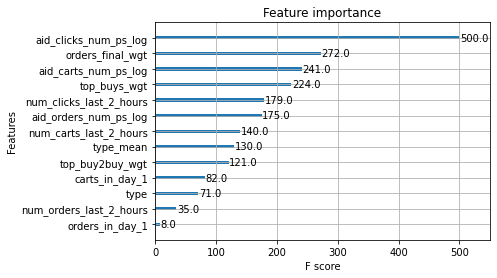

In [46]:
xgb_parms['learning_rate'] = 0.4
xgb_parms['max_depth'] = 8
xgb_parms['gamma'] = 15.0
xgb_parms['subsample'] = 0.8
xgb_parms['colsample_bytree'] = 1
xgb_parms['min_child_weight'] = 200
xgb_parms['max_delta_step'] = 0
xgb_parms['eta'] = 0.1

for valid_fold_num in cfg.train_folds:
    print('Fold', valid_fold_num)

    # X_train = train_orders
    X_train = train_orders.loc[train_orders.fold != valid_fold_num]
    X_train = X_train.sort_values('session')
    
    y_train = X_train['gt']
    groups = X_train.groupby('session').size().to_frame('size')['size']
    X_train = X_train[feature_cols['orders']]
    
    X_valid = train_orders.loc[train_orders.fold == valid_fold_num]
    X_valid = X_valid.sort_values('session')
    
    y_valid = X_valid['gt']
    val_groups = X_valid.groupby('session').size().to_frame('size')['size']
    X_valid = X_valid[feature_cols['orders']]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, group=groups)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, group=val_groups)

    gc.collect()

    model = xgb.train(
        xgb_parms,
        dtrain=dtrain,
        evals=[(dtrain,'train'),(dvalid,'valid')],
        num_boost_round=100,
        verbose_eval=10,
        early_stopping_rounds=30,
    )

    model.save_model(f'XGB_fold{valid_fold_num}_orders.xgb')

del train_orders
del X_train, y_train, X_valid, y_valid, dtrain, dvalid

_ = xgb.plot_importance(model)

calc_val_score('orders')

# 6510660759129224
# 6514019737999648

In [47]:
del model
gc.collect()

21

Free - 14645 MiB 	Total - 16280 MiB


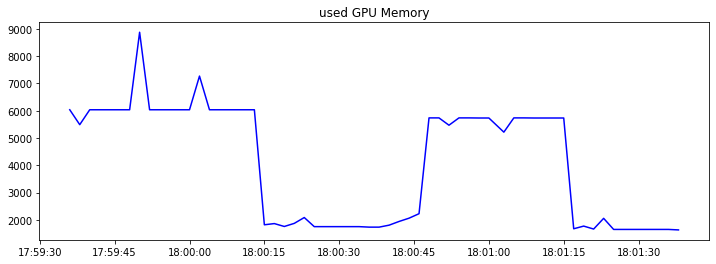

In [48]:
sleep(2)
print_gpu_mem_info()
plot_gpu_usage()

In [49]:
# assert False

# Predict on validation data

In [50]:
print('Validation:')
print('Valid num', cfg.val_fold)

Validation:
Valid num 0


In [51]:
events_names = ['clicks', 'carts', 'orders']

preds = {}
for event_name in events_names:
    print(event_name)
    
    model = xgb.Booster()
    model.load_model(f'XGB_fold{valid_fold_num}_{event_name}.xgb')
    model.set_param({'predictor': 'gpu_predictor'})
    
    preds[event_name] = []
    for i,f in enumerate(val_candidates_files[event_name]):
        print(i, end=' ')

        val_candidates = cudf.read_parquet(f)
        val_candidates = val_candidates.sort_values('session')
        
        groups = val_candidates.groupby('session').size().to_frame('size')['size']
        dtest = xgb.DMatrix(data=val_candidates[feature_cols[event_name]], group=groups)

        preds[event_name].append(model.predict(dtest))
        del dtest, val_candidates
    
    preds[event_name] = np.concatenate(preds[event_name], axis=None)
    np.save(f'val_preds_{event_name}.npy', preds[event_name])
    print()

clicks
0 1 2 3 4 5 6 7 8 9 
carts
0 1 2 3 4 5 6 7 8 9 
orders
0 1 2 3 4 5 6 7 8 9 


In [52]:
# gc.collect()
# time.sleep(2)
# print_gpu_mem_info()
# plot_gpu_usage()

## Create val submission

In [53]:
events_names = ['clicks', 'carts', 'orders']
# events_names = ['clicks']

predictions = {}
sub = {}
for event_name in events_names:
    print(event_name)
    
    # Add predictions to test dataframe

    predictions[event_name] = get_val_data(event_name)[['session','aid']]
    # print(predictions[event_name].session.nunique())    
    
    # predictions[event_name]['pred'] = preds[event_name]
    predictions[event_name]['pred'] = preds[event_name]

    # Pick top 20 predictions

    predictions[event_name] = predictions[event_name].sort_values(['session','pred'], ascending=[True,False]).reset_index(drop=True)
    predictions[event_name]['n'] = predictions[event_name].groupby('session').aid.cumcount().astype('int8')
    predictions[event_name] = predictions[event_name].loc[predictions[event_name].n<20]
    del predictions[event_name]['pred']
    del predictions[event_name]['n']
    # print(predictions[event_name].shape)
    # display(predictions[event_name].head())

    # Transform (session,aid) pairs to (session,string of all aids) pairs
    predictions[event_name] = predictions[event_name].to_pandas() # it is faster to do next functions in pandas then in cudf
    sub[event_name] = predictions[event_name].groupby('session').aid.apply(list)
    del predictions[event_name]
    sub[event_name] = sub[event_name].to_frame().reset_index()
    sub[event_name].aid = sub[event_name].aid.apply(lambda x: " ".join(map(str,x)))
    # preview_df(sub[event_name])

    # Add session type for each session num
    to_add_str = '_' + event_name
    sub[event_name]['session'] = sub[event_name].session.astype('str') + to_add_str

    gc.collect()
    time.sleep(2)

clicks
carts
orders


In [54]:
submission = pd.concat([sub['clicks'], sub['carts'], sub['orders']], axis=0).reset_index(drop=True)
submission.head()

submission.columns = ['session_type','labels']

submission = submission.sort_values(['session_type']).reset_index(drop=True)
print(submission.shape)
submission.head()

(1080750, 2)


,session_type,labels
0,11098532_carts,876469 7651 408667 108125 932046 706003 175405...
1,11098532_clicks,876469 7651 108125 1402537 659399 738098 61292...
2,11098532_orders,876469 7651 408667 1720259 108125 669555 47668...
3,11098537_carts,1409748 742569 5947 1177489 358965 1627951 118...
4,11098537_clicks,1409748 358965 336024 1189975 742569 1744125 6...


## Score val submission

In [55]:
print('Valid num', cfg.val_fold)

Valid num 0


In [56]:
%%time

try:
    pred_df = submission

    # COMPUTE METRIC
    score = 0
    weights = {'clicks': 0.10, 'carts': 0.30, 'orders': 0.60}
    for t in ['clicks','carts','orders']:
        sub = pred_df.loc[pred_df.session_type.str.contains(t)].copy()
        sub['session'] = sub.session_type.apply(lambda x: int(x.split('_')[0]))
        sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])
        val_labels = pd.read_parquet(train_labels_path)
        val_labels = val_labels.loc[val_labels['type']==t]

        val_labels = pd.merge(val_labels, df_fold.to_pandas(), on='session')
        val_labels = val_labels.loc[val_labels.fold == cfg.val_fold]
        del val_labels['fold']

        val_labels = val_labels.merge(sub, how='left', on=['session'])
#         display(val_labels)
        val_labels['hits'] = val_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
        val_labels['gt_count'] = val_labels.ground_truth.str.len().clip(0,20)
        recall = val_labels['hits'].sum() / val_labels['gt_count'].sum()
        score += weights[t]*recall
        print(f'{t} recall =',recall)

    print('=============')
    print('Overall Recall =',score)
    print('=============')
except Exception as e:
    print('Exception:')
    print(e)

clicks recall = 0.5164914958383284
carts recall = 0.4054100888973608
orders recall = 0.651337993250052
Overall Recall = 0.5640749722030722
CPU times: user 25.6 s, sys: 1.11 s, total: 26.7 s
Wall time: 26.3 s


In [57]:
try:
    del model, df, predictions, preds, val_labels, pred_df
except Exception as e:
    print(e)
gc.collect()

59

# Predict on test data

In [58]:
print('Create test submission:')

Create test submission:


## Predict

In [59]:
print('Test folds', cfg.test_folds)

Test folds [0, 1, 2, 3, 4]


In [60]:
# Calc length of test files, it is needed in calculating predictions

len_test = {}
for ev in ['clicks', 'carts', 'orders']:
    len_test[ev] = 0
    for f in test_candidates_files[ev]:
        df = cudf.read_parquet(f)
        len_test[ev] += len(df)
print(len_test)

{'clicks': 62791052, 'carts': 66302616, 'orders': 65922226}


In [61]:
events_names = ['clicks', 'carts', 'orders']

preds = {}
for event_name in events_names:
    print(event_name)
    preds[event_name] = np.zeros(len_test[event_name])
    
    for valid_fold_num in cfg.test_folds:
        print('Fold', valid_fold_num, end=' ')
        
        model = xgb.Booster()
        model.load_model(f'XGB_fold{valid_fold_num}_{event_name}.xgb')
        model.set_param({'predictor': 'gpu_predictor'})

        preds_chunk = []
        for f in test_candidates_files[event_name]:
            
            test = cudf.read_parquet(f)
            test = test.sort_values('session')
            groups = test.groupby('session').size().to_frame('size')['size']
            dtest = xgb.DMatrix(data=test[feature_cols[event_name]], group=groups)
            
            preds_chunk.append(model.predict(dtest))
            del dtest

        preds[event_name] += np.concatenate(preds_chunk, axis=None) / len(cfg.test_folds)
        print()
    
    np.save(f'preds_{event_name}.npy', preds[event_name])
    print()

clicks
Fold 0 
Fold 1 
Fold 2 
Fold 3 
Fold 4 

carts
Fold 0 
Fold 1 
Fold 2 
Fold 3 
Fold 4 

orders
Fold 0 
Fold 1 
Fold 2 
Fold 3 
Fold 4 



In [62]:
# preds={}
# preds['clicks'] = np.load('/kaggle/working/preds_clicks.npy')
# preds['carts'] = np.load('/kaggle/working/preds_carts.npy')
# preds['orders'] = np.load('/kaggle/working/preds_orders.npy')

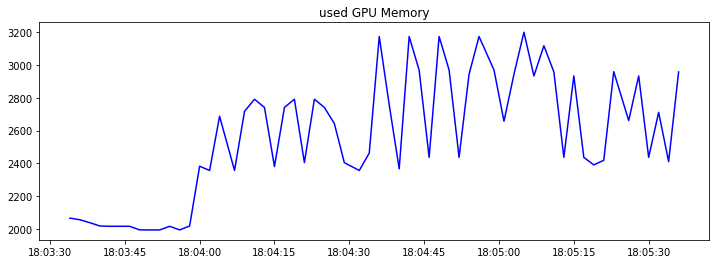

In [63]:
plot_gpu_usage()

# Create submission

In [64]:
def get_test_data(event):
    test_data = cudf.DataFrame()
    for f in test_candidates_files[event]:
        test_data = cudf.concat([test_data, cudf.read_parquet(f).sort_values('session')], ignore_index=True)
    test_data = test_data.reset_index(drop=True)
    test_data['session'] = test_data['session'].astype('int32')
    test_data['aid'] = test_data['aid'].astype('int32')
    return test_data

In [65]:
events_names = ['clicks', 'carts', 'orders']
# events_names = ['clicks']

predictions = {}
sub = {}
for event_name in events_names:
    print(event_name)

    # Add predictions to test dataframe
    
    predictions[event_name] = get_test_data(event_name)[['session','aid']]
    # print(predictions[event_name].session.nunique())    

    predictions[event_name]['pred'] = preds[event_name]

    # Pick top 20 predictions

    predictions[event_name] = predictions[event_name].sort_values(['session','pred'], ascending=[True,False]).reset_index(drop=True)
    predictions[event_name]['n'] = predictions[event_name].groupby('session').aid.cumcount().astype('int8')
    predictions[event_name] = predictions[event_name].loc[predictions[event_name].n<20]
    del predictions[event_name]['pred']
    del predictions[event_name]['n']
    # print(predictions[event_name].shape)
    # display(predictions[event_name].head())

    # Transform (session,aid) pairs to (session,string of all aids) pairs

    predictions[event_name] = predictions[event_name].to_pandas() # it is faster to do next functions in pandas then in cudf
    sub[event_name] = predictions[event_name].groupby('session').aid.apply(list)
    del predictions[event_name]
    sub[event_name] = sub[event_name].to_frame().reset_index()
    sub[event_name].aid = sub[event_name].aid.apply(lambda x: " ".join(map(str,x)))
    preview_df(sub[event_name])

    # Add session type for each session num
    to_add_str = '_' + event_name
    sub[event_name]['session'] = sub[event_name].session.astype('str') + to_add_str

    gc.collect()
    time.sleep(2)

clicks


/opt/conda/lib/python3.7/site-packages/cudf/core/frame.py:2600: UserWarning: When using a sequence of booleans for `ascending`, `na_position` flag is not yet supported and defaults to treating nulls as greater than all numbers
  "When using a sequence of booleans for `ascending`, "


1,671,803


,session,aid
0,12899779,59625 1253524 737445 339846 94230 1138236 7316...


carts


/opt/conda/lib/python3.7/site-packages/cudf/core/frame.py:2600: UserWarning: When using a sequence of booleans for `ascending`, `na_position` flag is not yet supported and defaults to treating nulls as greater than all numbers
  "When using a sequence of booleans for `ascending`, "


1,671,803


,session,aid
0,12899779,59625 731692 1253524 1790770 448688 469285 637...


orders


/opt/conda/lib/python3.7/site-packages/cudf/core/frame.py:2600: UserWarning: When using a sequence of booleans for `ascending`, `na_position` flag is not yet supported and defaults to treating nulls as greater than all numbers
  "When using a sequence of booleans for `ascending`, "


1,671,803


,session,aid
0,12899779,59625 731692 1253524 1790770 737445 448688 696...


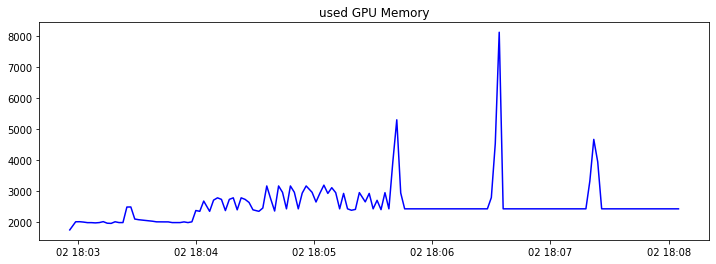

In [66]:
plot_gpu_usage(5)

* Concatenate all event types

In [67]:
submission = pd.concat([sub['clicks'], sub['carts'], sub['orders']], axis=0).reset_index(drop=True)
submission.columns = ['session_type','labels']
submission = submission.sort_values(['session_type']).reset_index(drop=True)
preview_df(submission, 5)

5,015,409


,session_type,labels
0,12899779_carts,59625 731692 1253524 1790770 448688 469285 637...
1,12899779_clicks,59625 1253524 737445 339846 94230 1138236 7316...
2,12899779_orders,59625 731692 1253524 1790770 737445 448688 696...
3,12899780_carts,736515 582732 973453 1142000 1758603 487136 10...
4,12899780_clicks,1142000 973453 736515 582732 487136 1758603 88...


* Save submission as csv

In [68]:
submission.to_csv('submission.csv', index=False)

In [69]:
display(submission)

,session_type,labels
0,12899779_carts,59625 731692 1253524 1790770 448688 469285 637...
1,12899779_clicks,59625 1253524 737445 339846 94230 1138236 7316...
2,12899779_orders,59625 731692 1253524 1790770 737445 448688 696...
3,12899780_carts,736515 582732 973453 1142000 1758603 487136 10...
4,12899780_clicks,1142000 973453 736515 582732 487136 1758603 88...
...,...,...
5015404,14571580_clicks,202353 1314576 433425 871658 1231403 925638 67...
5015405,14571580_orders,202353 888228 387358 891417 904620 985380 3560...
5015406,14571581_carts,1100210 1392029 622489 1684953 940217 1550662 ...
5015407,14571581_clicks,1100210 1684953 462056 1158237 1401429 622489 ...
